Dataset : https://www.kaggle.com/datasets/prachi13/customer-analytics

# E-Commerce Shipment Delay Prediction

## Project Goal
The goal of this project is to analyze an e-commerce shipping dataset to identify the key drivers of shipment delays. I will build and compare several machine learning models to find the most accurate and robust model for predicting whether a shipment will be late (Class 0).

The primary business metric for success is **Recall for Class 0**, as it is more costly to *miss* a late shipment than to *falsely flag* an on-time one.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, make_scorer, f1_score, precision_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, roc_auc_score

In [4]:
df = pd.read_csv('train.csv')
df.sample(10)

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
2481,2482,B,Flight,3,3,142,3,medium,M,23,1897,1
6683,6684,F,Ship,4,4,157,2,low,M,9,4491,1
4228,4229,C,Road,6,5,220,3,medium,M,1,5508,0
3245,3246,F,Ship,3,4,136,3,medium,M,2,4524,1
3331,3332,F,Ship,4,4,216,2,medium,M,2,5840,1
2106,2107,D,Ship,3,1,111,4,low,F,8,1620,1
7915,7916,F,Ship,3,1,213,2,low,M,6,4747,0
2270,2271,A,Ship,4,2,251,3,low,F,10,3517,1
8528,8529,A,Ship,5,3,230,3,medium,F,7,4844,0
7463,7464,F,Ship,5,5,266,5,medium,M,7,1440,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


-----
##### Notes:
- columns need One Hot Encoding: Warehouse_block, Mode_of_Shipment, Gender
- Ordinal data: Customer_rating, Product_importance
----

In [6]:
print('unique values in categorical columns: \n')
for i in df.select_dtypes(include='object'):
    print(i, ':', df[str(i)].unique())

unique values in categorical columns: 

Warehouse_block : ['D' 'F' 'A' 'B' 'C']
Mode_of_Shipment : ['Flight' 'Ship' 'Road']
Product_importance : ['low' 'medium' 'high']
Gender : ['F' 'M']


In [7]:
df.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,10999.0,5500.000000,3175.282140,1.0,2750.5,5500.0,8249.5,10999.0
Customer_care_calls,10999.0,4.054459,1.141490,2.0,3.0,4.0,5.0,7.0
Customer_rating,10999.0,2.990545,1.413603,1.0,2.0,3.0,4.0,5.0
Cost_of_the_Product,10999.0,210.196836,48.063272,96.0,169.0,214.0,251.0,310.0
Prior_purchases,10999.0,3.567597,1.522860,2.0,3.0,3.0,4.0,10.0
Discount_offered,10999.0,13.373216,16.205527,1.0,4.0,7.0,10.0,65.0
Weight_in_gms,10999.0,3634.016729,1635.377251,1001.0,1839.5,4149.0,5050.0,7846.0
Reached.on.Time_Y.N,10999.0,0.596691,0.490584,0.0,0.0,1.0,1.0,1.0


In [9]:
df.shape

(10999, 12)

In [14]:
df['Reached.on.Time_Y.N'].value_counts()

Reached.on.Time_Y.N
1    6563
0    4436
Name: count, dtype: int64

#### to predict whether the shipment is ontime or not, this is imbalanced data. we should consider it later.

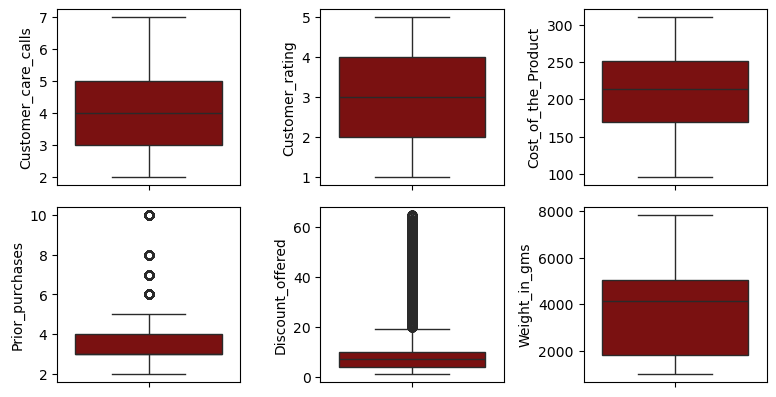

In [17]:
plt.figure(figsize=(8, 6))
for i, col in enumerate(df.drop(['ID', 'Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'Reached.on.Time_Y.N'], axis=1).columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=df, y=col, color='darkred')
plt.tight_layout()
plt.show()

In [38]:
df[df['Discount_offered'] > 25].sort_values(by='Discount_offered', ascending=False)

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
2437,2438,F,Ship,4,5,206,3,low,F,65,2598,1
2417,2418,F,Ship,3,4,228,2,medium,M,65,3943,1
1449,1450,B,Ship,3,3,162,2,medium,M,65,1184,1
2111,2112,F,Ship,3,2,212,2,medium,F,65,3776,1
2140,2141,C,Ship,3,3,160,3,medium,F,65,1228,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1694,1695,A,Ship,3,1,180,2,low,M,26,1715,1
1802,1803,A,Ship,3,5,249,2,low,F,26,2029,1
2771,2772,F,Ship,6,5,249,5,medium,M,26,3897,1
802,803,C,Road,3,2,262,2,low,F,26,2370,1


In [19]:
df['Mode_of_Shipment'].value_counts()

Mode_of_Shipment
Ship      7462
Flight    1777
Road      1760
Name: count, dtype: int64

In [21]:
df_updated = pd.get_dummies(df, columns=['Warehouse_block', 'Mode_of_Shipment', 'Gender'], dtype=int)
df_updated.head()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Gender_F,Gender_M
0,1,4,2,177,3,low,44,1233,1,0,0,0,1,0,1,0,0,1,0
1,2,4,5,216,2,low,59,3088,1,0,0,0,0,1,1,0,0,0,1
2,3,2,2,183,4,low,48,3374,1,1,0,0,0,0,1,0,0,0,1
3,4,3,3,176,4,medium,10,1177,1,0,1,0,0,0,1,0,0,0,1
4,5,2,2,184,3,medium,46,2484,1,0,0,1,0,0,1,0,0,1,0


In [23]:
print(df_updated['Product_importance'].unique())

importance_mapping = {
    'low': 0,
    'medium': 1,
    'high': 2
}

df_updated['Product_importance'] = df_updated['Product_importance'].map(importance_mapping)
df_updated.head()

['low' 'medium' 'high']


,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Gender_F,Gender_M
0,1,4,2,177,3,0,44,1233,1,0,0,0,1,0,1,0,0,1,0
1,2,4,5,216,2,0,59,3088,1,0,0,0,0,1,1,0,0,0,1
2,3,2,2,183,4,0,48,3374,1,1,0,0,0,0,1,0,0,0,1
3,4,3,3,176,4,1,10,1177,1,0,1,0,0,0,1,0,0,0,1
4,5,2,2,184,3,1,46,2484,1,0,0,1,0,0,1,0,0,1,0


In [24]:
df_updated.columns

Index(['ID', 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product',
       'Prior_purchases', 'Product_importance', 'Discount_offered',
       'Weight_in_gms', 'Reached.on.Time_Y.N', 'Warehouse_block_A',
       'Warehouse_block_B', 'Warehouse_block_C', 'Warehouse_block_D',
       'Warehouse_block_F', 'Mode_of_Shipment_Flight', 'Mode_of_Shipment_Road',
       'Mode_of_Shipment_Ship', 'Gender_F', 'Gender_M'],
      dtype='object')

In [25]:
df_updated = df_updated.drop(['ID', 'Gender_M'], axis=1)
df_updated.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Gender_F
0,4,2,177,3,0,44,1233,1,0,0,0,1,0,1,0,0,1
1,4,5,216,2,0,59,3088,1,0,0,0,0,1,1,0,0,0
2,2,2,183,4,0,48,3374,1,1,0,0,0,0,1,0,0,0
3,3,3,176,4,1,10,1177,1,0,1,0,0,0,1,0,0,0
4,2,2,184,3,1,46,2484,1,0,0,1,0,0,1,0,0,1


In [26]:
df_updated.shape

(10999, 17)

In [27]:
df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Customer_care_calls      10999 non-null  int64
 1   Customer_rating          10999 non-null  int64
 2   Cost_of_the_Product      10999 non-null  int64
 3   Prior_purchases          10999 non-null  int64
 4   Product_importance       10999 non-null  int64
 5   Discount_offered         10999 non-null  int64
 6   Weight_in_gms            10999 non-null  int64
 7   Reached.on.Time_Y.N      10999 non-null  int64
 8   Warehouse_block_A        10999 non-null  int32
 9   Warehouse_block_B        10999 non-null  int32
 10  Warehouse_block_C        10999 non-null  int32
 11  Warehouse_block_D        10999 non-null  int32
 12  Warehouse_block_F        10999 non-null  int32
 13  Mode_of_Shipment_Flight  10999 non-null  int32
 14  Mode_of_Shipment_Road    10999 non-null  int32
 15  Mo

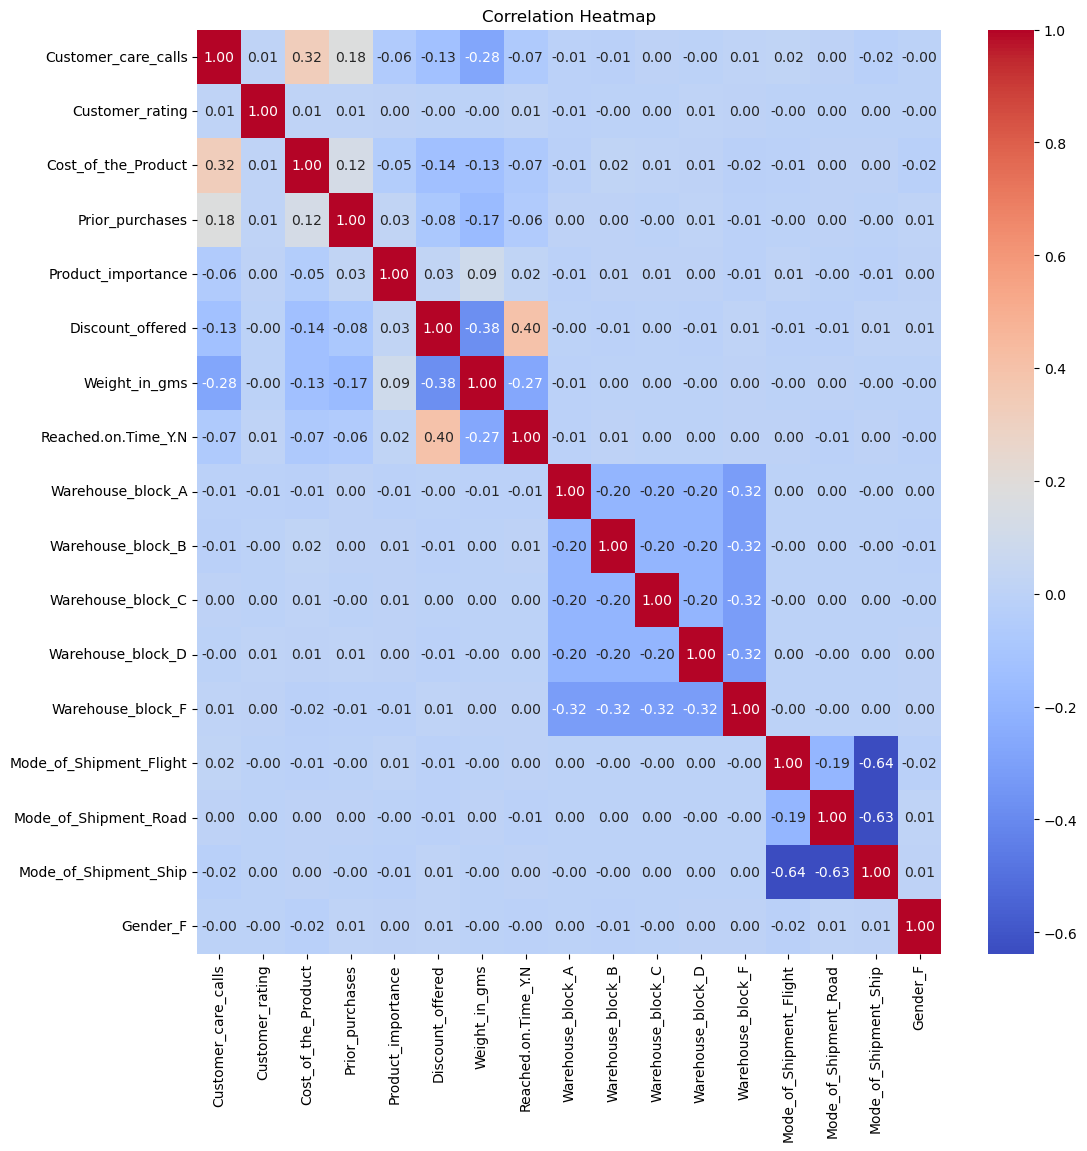

In [28]:
plt.figure(figsize=(12, 12))
sns.heatmap(df_updated.select_dtypes(include='number').corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [29]:
numerical_cols = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product',
       'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'Product_importance']

In [30]:
X, y = df_updated.drop(['Reached.on.Time_Y.N'], axis=1), df['Reached.on.Time_Y.N']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [31]:
scaler = StandardScaler()
scaler.fit(X_train[numerical_cols])

StandardScaler()

In [32]:
X_train_scaled_numerical = pd.DataFrame(scaler.transform(X_train[numerical_cols]), 
                                        columns=numerical_cols, 
                                        index=X_train.index)

X_test_scaled_numerical = pd.DataFrame(scaler.transform(X_test[numerical_cols]), 
                                       columns=numerical_cols, 
                                       index=X_test.index)

In [33]:
one_hot_cols = [col for col in X_train.columns if col not in numerical_cols]

In [34]:
X_train_processed = pd.concat([X_train_scaled_numerical, X_train[one_hot_cols]], axis=1)
X_test_processed = pd.concat([X_test_scaled_numerical, X_test[one_hot_cols]], axis=1)

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.54      0.86      0.67       887
           1       0.84      0.52      0.64      1313

    accuracy                           0.65      2200
   macro avg       0.69      0.69      0.65      2200
weighted avg       0.72      0.65      0.65      2200


--- Confusion Matrix ---


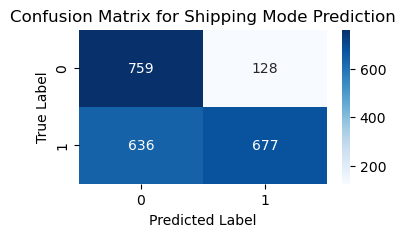

In [43]:
log_model = LogisticRegression(random_state=42, class_weight='balanced')
log_model.fit(X_train_processed, y_train)

predictions = log_model.predict(X_test_processed)

print("--- Classification Report ---")
print(classification_report(y_test, predictions))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=log_model.classes_, yticklabels=log_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Shipping Mode Prediction')
plt.show()

In [36]:
# L2 Coefficients
coeffs_l2 = pd.Series(log_model.coef_[0], index=X_train_processed.columns)
print("\\n--- L2 (Ridge) Coefficients ---")
print(coeffs_l2.sort_values(ascending=False))


\n--- L2 (Ridge) Coefficients ---
Discount_offered           1.915584
Mode_of_Shipment_Flight    0.165089
Warehouse_block_D          0.147353
Mode_of_Shipment_Ship      0.128587
Mode_of_Shipment_Road      0.103661
Warehouse_block_B          0.084724
Warehouse_block_F          0.079439
Product_importance         0.059868
Warehouse_block_A          0.048080
Warehouse_block_C          0.037740
Customer_rating            0.033424
Gender_F                  -0.039640
Cost_of_the_Product       -0.092571
Prior_purchases           -0.125056
Customer_care_calls       -0.146448
Weight_in_gms             -0.386939
dtype: float64


\n--- New Model (L1/Lasso Regularization) ---
              precision    recall  f1-score   support

           0       0.54      0.86      0.67       887
           1       0.85      0.51      0.64      1313

    accuracy                           0.65      2200
   macro avg       0.70      0.69      0.65      2200
weighted avg       0.73      0.65      0.65      2200

\n--- L1 (Lasso) Coefficients ---
Discount_offered           1.847936
Product_importance         0.052664
Warehouse_block_D          0.046064
Customer_rating            0.027848
Mode_of_Shipment_Flight    0.005753
Warehouse_block_A          0.000000
Warehouse_block_B          0.000000
Warehouse_block_C          0.000000
Warehouse_block_F          0.000000
Mode_of_Shipment_Road      0.000000
Mode_of_Shipment_Ship      0.000000
Gender_F                  -0.003673
Cost_of_the_Product       -0.085944
Prior_purchases           -0.117061
Customer_care_calls       -0.140613
Weight_in_gms             -0.374787
dtype: float64
\n

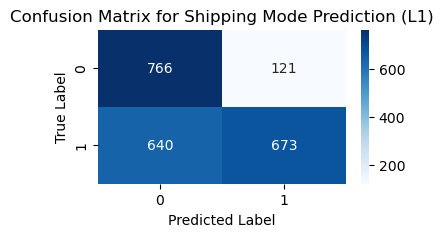

In [39]:
# l1=lasso regularization

log_model_l1 = LogisticRegression(penalty='l1', C=0.1, solver='liblinear', random_state=42, class_weight='balanced')
log_model_l1.fit(X_train_processed, y_train)
predictions_l1 = log_model_l1.predict(X_test_processed)

print("\\n--- New Model (L1/Lasso Regularization) ---")
print(classification_report(y_test, predictions_l1))


# L1 Coefficients
coeffs_l1 = pd.Series(log_model_l1.coef_[0], index=X_train_processed.columns)
print("\\n--- L1 (Lasso) Coefficients ---")
print(coeffs_l1.sort_values(ascending=False))

# 4. Generate and Visualize the Confusion Matrix for the L1 model
print("\\n--- Confusion Matrix (L1/Lasso Model) ---")
cm = confusion_matrix(y_test, predictions_l1)

plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=log_model_l1.classes_, yticklabels=log_model_l1.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Shipping Mode Prediction (L1)')
plt.show()

AUC Score: 0.7171


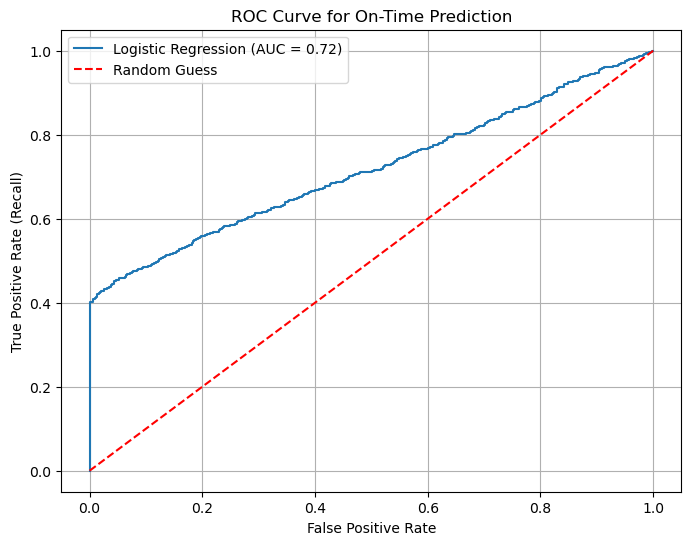

In [40]:
# 1. Get predicted probabilities for the 'positive' class (class 1)
y_pred_proba = log_model_l1.predict_proba(X_test_processed)[:, 1]

# 2. Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

# 3. Calculate the points for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# 4. Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess') # Dashed line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for On-Time Prediction')
plt.legend()
plt.grid()
plt.show()

-----
#### Note:
although the accuracy of the model is acceptable and is not that high, it has a good performance on detecting the late shipments (recall = 86%)
now, we're gonna test other approaches to see what will happen on the model performance.

1): Log Transform on the column 'Discount_offered': When data is super-skewed like this, a pro-move is to apply a log transformation before scaling. This "pulls in" the long tail and makes the distribution look more normal, which linear models love.

2): (Feature Engineering): Since you identified a clear business rule (a 75/25 split), you can create a new feature to give the model this hint explicitly.

-----

In [64]:
# approach 1: Log Transform on the column 'Discount_offered'

In [65]:
df_updated1 = df_updated.copy()
df_updated1['Discount_Log'] = np.log1p(df_updated1['Discount_offered'])

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.55      0.93      0.69       887
           1       0.91      0.48      0.63      1313

    accuracy                           0.66      2200
   macro avg       0.73      0.70      0.66      2200
weighted avg       0.76      0.66      0.65      2200


--- Confusion Matrix ---


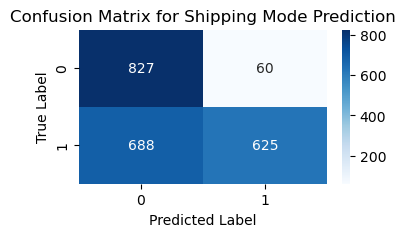

In [66]:
X, y = df_updated1.drop(['Reached.on.Time_Y.N'], axis=1), df_updated1['Reached.on.Time_Y.N']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train[numerical_cols])

X_train_scaled_numerical = pd.DataFrame(scaler.transform(X_train[numerical_cols]), 
                                        columns=numerical_cols, 
                                        index=X_train.index)

X_test_scaled_numerical = pd.DataFrame(scaler.transform(X_test[numerical_cols]), 
                                       columns=numerical_cols, 
                                       index=X_test.index)

one_hot_cols = [col for col in X_train.columns if col not in numerical_cols]

X_train_processed = pd.concat([X_train_scaled_numerical, X_train[one_hot_cols]], axis=1)
X_test_processed = pd.concat([X_test_scaled_numerical, X_test[one_hot_cols]], axis=1)


log_model = LogisticRegression(random_state=42, class_weight='balanced')
log_model.fit(X_train_processed, y_train)

predictions = log_model.predict(X_test_processed)

print("--- Classification Report ---")
print(classification_report(y_test, predictions))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=log_model.classes_, yticklabels=log_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Shipping Mode Prediction')
plt.show()

Recall improved!

In [61]:
# approach 2: (Feature Engineering)

In [62]:
df_updated2 = df_updated.copy()
df_updated2['is_high_discount'] = (df_updated2['Discount_offered'] > 20).astype(int)

numerical_cols1 = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product',
       'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'Product_importance', 'is_high_discount']

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.54      0.92      0.68       887
           1       0.90      0.48      0.62      1313

    accuracy                           0.66      2200
   macro avg       0.72      0.70      0.65      2200
weighted avg       0.76      0.66      0.65      2200


--- Confusion Matrix ---


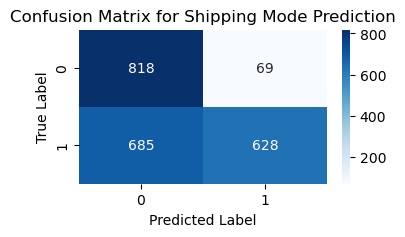

In [63]:
X, y = df_updated2.drop(['Reached.on.Time_Y.N'], axis=1), df_updated2['Reached.on.Time_Y.N']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train[numerical_cols1])

X_train_scaled_numerical = pd.DataFrame(scaler.transform(X_train[numerical_cols1]), 
                                        columns=numerical_cols1, 
                                        index=X_train.index)

X_test_scaled_numerical = pd.DataFrame(scaler.transform(X_test[numerical_cols1]), 
                                       columns=numerical_cols1, 
                                       index=X_test.index)

one_hot_cols = [col for col in X_train.columns if col not in numerical_cols1]

X_train_processed = pd.concat([X_train_scaled_numerical, X_train[one_hot_cols]], axis=1)
X_test_processed = pd.concat([X_test_scaled_numerical, X_test[one_hot_cols]], axis=1)


log_model = LogisticRegression(random_state=42, class_weight='balanced')
log_model.fit(X_train_processed, y_train)

predictions = log_model.predict(X_test_processed)

print("--- Classification Report ---")
print(classification_report(y_test, predictions))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=log_model.classes_, yticklabels=log_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Shipping Mode Prediction')
plt.show()

----
#### NOTE!
So, amonge the base model, approach 1 and approach 2 --> approach 1 has better performance!

----

#### Testing another algorihtm --> KNN:

In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# 1. Initialize the KNN model
# 'n_neighbors' is our 'k'. 5 is a common and good starting point.
knn_model = KNeighborsClassifier(n_neighbors=25)

# 2. Train the model on the same processed training data
knn_model.fit(X_train_processed, y_train)

# 3. Make new predictions
predictions_knn = knn_model.predict(X_test_processed)

# 4. Print the new classification report
print("--- K-Nearest Neighbors (KNN) Classification Report ---")
print(classification_report(y_test, predictions_knn))

--- K-Nearest Neighbors (KNN) Classification Report ---
              precision    recall  f1-score   support

           0       0.55      0.72      0.63       887
           1       0.76      0.61      0.68      1313

    accuracy                           0.65      2200
   macro avg       0.66      0.66      0.65      2200
weighted avg       0.68      0.65      0.66      2200



In [69]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

k_values = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 31]
f1_scores = []

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_processed, y_train)
    predictions_knn = knn_model.predict(X_test_processed)
    # Using 'macro' average to treat both classes equally
    score = f1_score(y_test, predictions_knn, average='macro')
    f1_scores.append(score)
    print(f"k = {k}, Macro F1-Score = {score:.4f}")

# Find the best k
best_k = k_values[f1_scores.index(max(f1_scores))]
print(f"\nBest k is: {best_k}")

k = 3, Macro F1-Score = 0.6215
k = 5, Macro F1-Score = 0.6291
k = 7, Macro F1-Score = 0.6237
k = 9, Macro F1-Score = 0.6344
k = 11, Macro F1-Score = 0.6296
k = 13, Macro F1-Score = 0.6214
k = 15, Macro F1-Score = 0.6292
k = 17, Macro F1-Score = 0.6435
k = 19, Macro F1-Score = 0.6440
k = 21, Macro F1-Score = 0.6471
k = 23, Macro F1-Score = 0.6398
k = 25, Macro F1-Score = 0.6509
k = 27, Macro F1-Score = 0.6476
k = 31, Macro F1-Score = 0.6478

Best k is: 25


k = 1, Error Rate = 0.3673
k = 3, Error Rate = 0.3691
k = 5, Error Rate = 0.3632
k = 7, Error Rate = 0.3695
k = 9, Error Rate = 0.3609
k = 11, Error Rate = 0.3659
k = 13, Error Rate = 0.3750
k = 15, Error Rate = 0.3668
k = 17, Error Rate = 0.3532
k = 19, Error Rate = 0.3532
k = 21, Error Rate = 0.3505
k = 23, Error Rate = 0.3582
k = 25, Error Rate = 0.3473
k = 27, Error Rate = 0.3509
k = 29, Error Rate = 0.3518
k = 31, Error Rate = 0.3514
k = 33, Error Rate = 0.3536


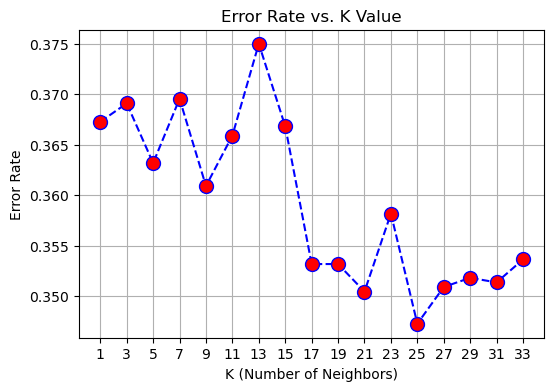


K with minimum error rate: 25


In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score 
import matplotlib.pyplot as plt
import numpy as np

# Define a range of k values to test (odd numbers are usually preferred)
k_range = range(1, 35, 2) # e.g., 1, 3, 5, ..., 21
error_rates = []

# Loop through each k value
for k in k_range:
    # Initialize and train the KNN model
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_processed, y_train)

    # Make predictions on the test set
    predictions_knn = knn_model.predict(X_test_processed)

    # Calculate the error rate (1 - accuracy) and store it
    error_rate = 1 - accuracy_score(y_test, predictions_knn)
    error_rates.append(error_rate)
    print(f"k = {k}, Error Rate = {error_rate:.4f}")

# Plot the k values vs. error rates
plt.figure(figsize=(6, 4))
plt.plot(k_range, error_rates, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Error Rate')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# You can also programmatically find the k with the minimum error,
# though visually inspecting the 'elbow' is often best
min_error_k = k_range[np.argmin(error_rates)]
print(f"\nK with minimum error rate: {min_error_k}")

----
##### NOTE:
the LogRegg (approach1) is the champion so far!

----

#### Model 3:
Implementing SVM model:

In [82]:
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, C=1, gamma='scale')  # RBF is usually a good default choice
svm_model.fit(X_train_processed, y_train)

predictions_svm = svm_model.predict(X_test_processed)

# 4. Print the new classification report
print("--- SVM Classification Report ---")
print(classification_report(y_test, predictions_svm))


--- SVM Classification Report ---
              precision    recall  f1-score   support

           0       0.54      0.99      0.70       887
           1       0.99      0.44      0.61      1313

    accuracy                           0.66      2200
   macro avg       0.77      0.72      0.66      2200
weighted avg       0.81      0.66      0.65      2200



AUC Score: 0.7353


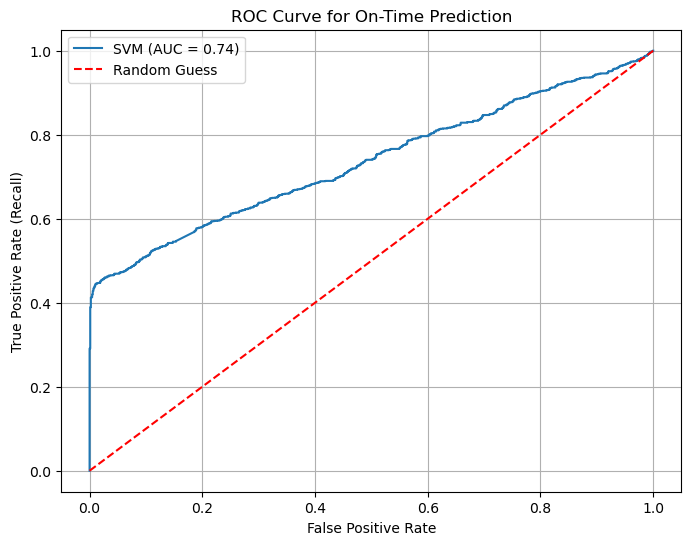

In [83]:
# 1. Get predicted probabilities for the 'positive' class (class 1)
y_pred_proba = svm_model.predict_proba(X_test_processed)[:, 1]

# 2. Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

# 3. Calculate the points for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# 4. Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'SVM (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess') # Dashed line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve for On-Time Prediction')
plt.legend()
plt.grid()
plt.show()

In [84]:
'''optimum threshold'''

# Calculate the G-Mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# An alternative is Youden's J-statistic: J = tpr - fpr
# Find the threshold that maximizes the G-Mean (or J-statistic)
ix = np.argmax(gmeans)
optimal_threshold = thresholds[ix]

print(f'Best Threshold={optimal_threshold:.4f}, G-Mean={gmeans[ix]:.4f}')
# You would now use this threshold for your final predictions:
# final_predictions = (y_pred_proba >= optimal_threshold).astype(int)

Best Threshold=0.4927, G-Mean=0.6841


---
#### NOTE:
SVM had a perfect recall on detecting the late shipments (class 0) --> 99%!

- other performance indicators (precision) for class 1 was not as same as logregg approach 1 and has more false alarms. in other words, the svm model was a paranoid guards and very suspecious!!
- also, the model run time was much higher the previous models!!
- choosing which model we had done so far, is a business tradeoff! in my opinion, logregg app 1 is better till now.

------

##### Decision Tree Algorithm


In [85]:
# tree model without pruning (full model)

X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
tree_model_full = DecisionTreeClassifier(random_state=42)
tree_model_full.fit(X_train_unscaled, y_train)
predictions_full = tree_model_full.predict(X_test_unscaled)
print(classification_report(y_test, predictions_full))
print(tree_model_full.get_depth())

              precision    recall  f1-score   support

           0       0.56      0.54      0.55       887
           1       0.70      0.71      0.70      1313

    accuracy                           0.64      2200
   macro avg       0.63      0.63      0.63      2200
weighted avg       0.64      0.64      0.64      2200

35


In [87]:
# tree model with pruning (pruned model)

tree_model_pruned = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model_pruned.fit(X_train_unscaled, y_train)
predictions_pruned = tree_model_pruned.predict(X_test_unscaled)
print(classification_report(y_test, predictions_pruned))


              precision    recall  f1-score   support

           0       0.56      0.98      0.71       887
           1       0.97      0.48      0.64      1313

    accuracy                           0.68      2200
   macro avg       0.76      0.73      0.68      2200
weighted avg       0.80      0.68      0.67      2200



In [88]:
print("\n--- Feature Importances from Pruned Tree ---")
importances = tree_model_pruned.feature_importances_
feature_importance_df = pd.Series(importances, index=X_train_unscaled.columns).sort_values(ascending=False)

print(feature_importance_df)


--- Feature Importances from Pruned Tree ---
Discount_Log               0.803732
Weight_in_gms              0.095667
Prior_purchases            0.077804
Cost_of_the_Product        0.018363
Customer_rating            0.004435
Warehouse_block_F          0.000000
Gender_F                   0.000000
Mode_of_Shipment_Ship      0.000000
Mode_of_Shipment_Road      0.000000
Mode_of_Shipment_Flight    0.000000
Customer_care_calls        0.000000
Warehouse_block_D          0.000000
Warehouse_block_C          0.000000
Warehouse_block_A          0.000000
Discount_offered           0.000000
Product_importance         0.000000
Warehouse_block_B          0.000000
dtype: float64


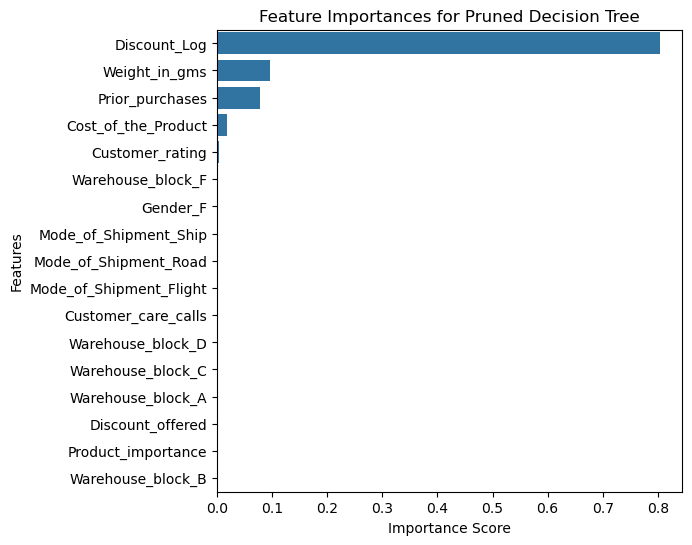

In [89]:
plt.figure(figsize=(6, 6))
sns.barplot(x=feature_importance_df, y=feature_importance_df.index)
plt.title('Feature Importances for Pruned Decision Tree')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()



--- Visualizing the Pruned Decision Tree ---


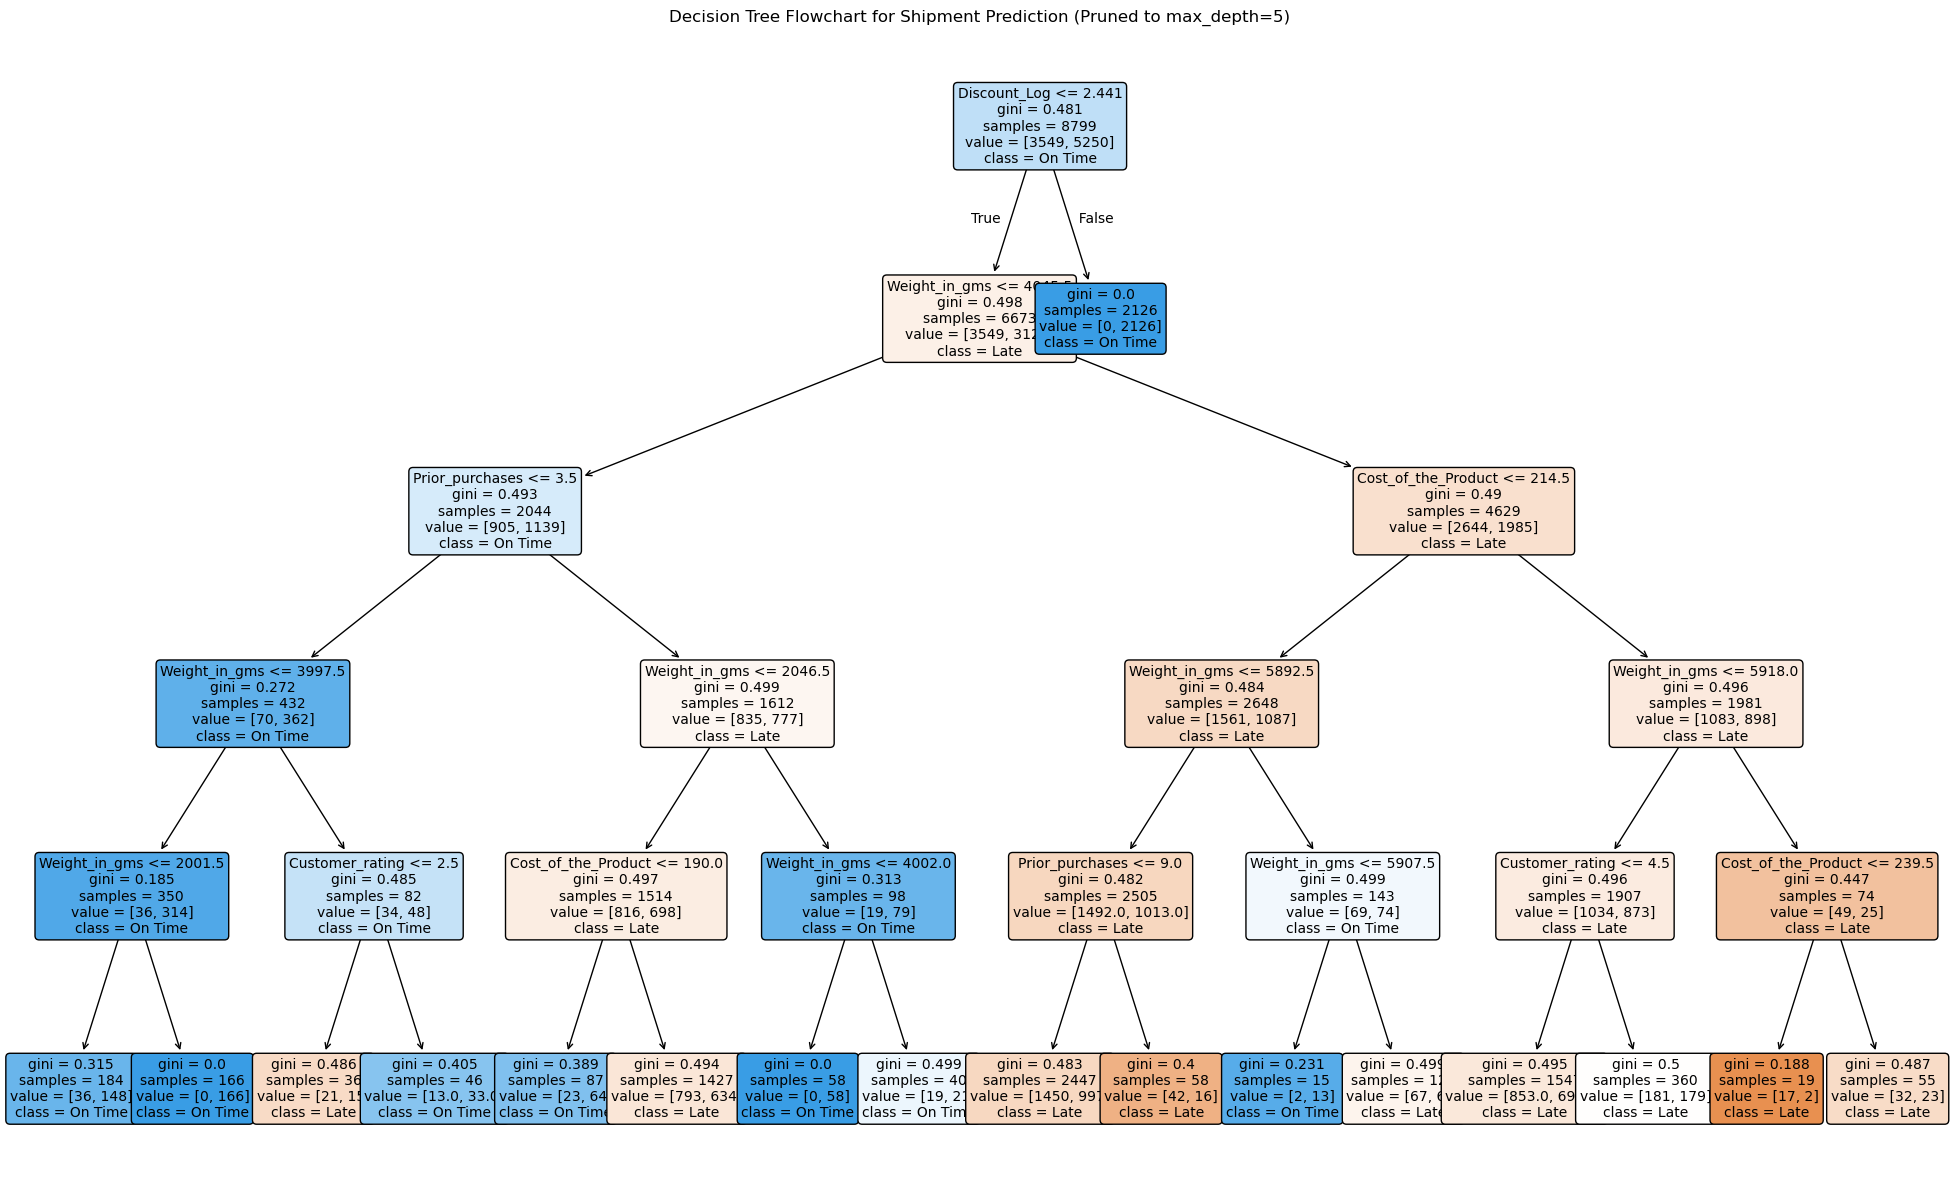

In [90]:
print("\n--- Visualizing the Pruned Decision Tree ---")
plt.figure(figsize=(25, 15)) # A larger figure size is needed for visibility
plot_tree(tree_model_pruned, 
          feature_names=X_train_unscaled.columns, 
          class_names=['Late', 'On Time'], # Class 0 is 'Late', Class 1 is 'On Time'
          filled=True, 
          rounded=True,
          fontsize=10)
plt.title("Decision Tree Flowchart for Shipment Prediction (Pruned to max_depth=5)")
plt.show()

KNN AUC: 0.7279
Decision Tree AUC: 0.736475


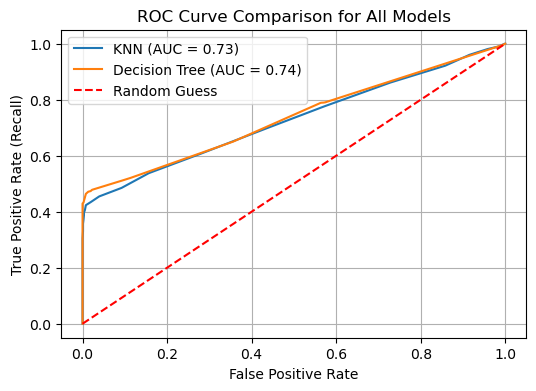

In [94]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- 1. Get Probabilities and Calculate AUC for each model ---

# Logistic Regression (use the balanced one, as it's your best LogReg model)
# Use the scaled test data
#y_pred_proba_logreg = log_model_l1.predict_proba(X_test_processed)[:, 1]
#auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg)
#fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_proba_logreg)

# K-Nearest Neighbors (make sure to use your best 'k')
# Use the scaled test data
# Note: Re-train the KNN model with your optimal 'k' if you haven't already
# For example: best_k = 19
# knn_model = KNeighborsClassifier(n_neighbors=best_k)
# knn_model.fit(X_train_processed, y_train)
y_pred_proba_knn = knn_model.predict_proba(X_test_processed)[:, 1]
auc_knn = roc_auc_score(y_test, y_pred_proba_knn)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)

# Decision Tree (use the pruned one)
# IMPORTANT: Use the UNSCALED test data for the tree
y_pred_proba_tree = tree_model_pruned.predict_proba(X_test_unscaled)[:, 1]
auc_tree = roc_auc_score(y_test, y_pred_proba_tree)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_proba_tree)


# --- 2. Print AUC Scores ---
#print(f"Logistic Regression AUC: {auc_logreg:.4f}")
print(f"KNN AUC: {auc_knn:.4f}")
print(f"Decision Tree AUC: {auc_tree:.6f}")


# --- 3. Plot all ROC curves on one graph ---
plt.figure(figsize=(6, 4))

# Plot Logistic Regression Curve
#plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {auc_logreg:.2f})')

# Plot KNN Curve
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.2f})')

# Plot Decision Tree Curve
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {auc_tree:.2f})')

# Plot Random Guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Final plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve Comparison for All Models')
plt.legend()
plt.grid()
plt.show()

----
#### Random Forests
----

In [95]:
'''simple model without considering imbalance data'''

# 1. Initialize the Random Forest model
# 'n_estimators' is the number of trees in the forest. 100 is a good default.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Train the model on your unscaled training data
rf_model.fit(X_train_unscaled, y_train)

# 3. Make predictions
predictions_rf = rf_model.predict(X_test_unscaled)
auc_rf = roc_auc_score(y_test, predictions_rf)

# 4. Print the classification report
print("--- Random Forest Classifier Report ---")
print(classification_report(y_test, predictions_rf))
print(auc_tree)

--- Random Forest Classifier Report ---
              precision    recall  f1-score   support

           0       0.56      0.72      0.63       887
           1       0.77      0.62      0.69      1313

    accuracy                           0.66      2200
   macro avg       0.67      0.67      0.66      2200
weighted avg       0.69      0.66      0.66      2200

0.736474900633763


In [96]:
'''considering imbalance data'''

# 1. Initialize the Random Forest model
# 'n_estimators' is the number of trees in the forest. 100 is a good default.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5, criterion='entropy', class_weight='balanced')

# 2. Train the model on your unscaled training data
rf_model.fit(X_train_unscaled, y_train)

# 3. Make predictions
predictions_rf = rf_model.predict(X_test_unscaled)
auc_rf_tuned = roc_auc_score(y_test, predictions_rf)

# 4. Print the classification report
print("--- Random Forest Classifier Report ---")
print(classification_report(y_test, predictions_rf))
print(auc_tree)

--- Random Forest Classifier Report ---
              precision    recall  f1-score   support

           0       0.56      0.99      0.71       887
           1       0.98      0.47      0.63      1313

    accuracy                           0.68      2200
   macro avg       0.77      0.73      0.67      2200
weighted avg       0.81      0.68      0.66      2200

0.736474900633763


a good sentence : This is not a failure of the Random Forest. It's a valuable insight into your data: 
the data likely has one or two overwhelmingly predictive features, which a simple model can exploit very well.

---
##### this is our new champion model!
now implementing another algorithm:

----
#### XGBoost Algorithm
----

In [97]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# 1. Initialize the XGBoost model
# We use 'objective':'binary:logistic' for a yes/no problem.
xgb_model = XGBClassifier(n_estimators=100, random_state=42, objective='binary:logistic')

# 2. Train the model on your unscaled training data
xgb_model.fit(X_train_unscaled, y_train)

# 3. Make predictions
predictions_xgb = xgb_model.predict(X_test_unscaled)

# 4. Print the classification report
print("--- XGBoost Classifier Report ---")
print(classification_report(y_test, predictions_xgb))

--- XGBoost Classifier Report ---
              precision    recall  f1-score   support

           0       0.55      0.65      0.59       887
           1       0.73      0.64      0.68      1313

    accuracy                           0.64      2200
   macro avg       0.64      0.64      0.64      2200
weighted avg       0.65      0.64      0.64      2200



In [98]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import numpy as np

# 1. Calculate the class weight.
# This is the ratio of 'Late' (0) to 'On Time' (1) shipments.
# Make sure to use y_train for this calculation!
weight_ratio = np.sum(y_train == 0) / np.sum(y_train == 1)
print(f"Calculated weight ratio: {weight_ratio:.2f}")

# 2. Initialize the TUNED XGBoost model
xgb_model_tuned = XGBClassifier(
    n_estimators=100,       # Number of trees
    random_state=42,        # For reproducibility
    objective='binary:logistic',
    max_depth=5,            # Prune the trees to prevent overfitting
    scale_pos_weight=weight_ratio  # Handle class imbalance
)

# 3. Train the tuned model on your unscaled training data
xgb_model_tuned.fit(X_train_unscaled, y_train)

# 4. Make predictions
predictions_xgb_tuned = xgb_model_tuned.predict(X_test_unscaled)

# 5. Print the classification report
print("\n--- TUNED XGBoost Classifier Report ---")
print(classification_report(y_test, predictions_xgb_tuned))

Calculated weight ratio: 0.68

--- TUNED XGBoost Classifier Report ---
              precision    recall  f1-score   support

           0       0.55      0.83      0.66       887
           1       0.83      0.55      0.66      1313

    accuracy                           0.66      2200
   macro avg       0.69      0.69      0.66      2200
weighted avg       0.72      0.66      0.66      2200



---
#### Tuned Random Forest is the undisputed champion model!
----

### If you like the analysis, please upvote it! thank you :)